# TitanQ Index Tracking Example

## Introduction

The index tracking problem in finance refers to the challenge of creating and managing a portfolio that closely replicates the performance of a specific stock market index, such as the S&P 500 or FTSE 100, while minimizing tracking error and associated costs. This problem is central to passive investment strategies, such as index funds and exchange-traded funds (ETFs), which aim to deliver the same returns as the index they track.

We analyze the Index Tracking problem as a non-linear quadratically constrained, quadratic optimization problem (MIQCP). This problem is challenging due to the non-linearity and the constraints, making it computationally intensive and difficult to solve directly especially when taking into account real world constraints and a large number of possible assets. 

In [ ]:
# Installing Python dependencies
!pip install -r "requirements.txt" --upgrade

#Importing required libraries
import numpy as np
import time
import matplotlib.pyplot as plt
#TitanQ specific imports
from titanq import Model, Vtype, Target
#Library to help with model generation
import model_generation

#Obtain your API key by contacting --> support@infinityq.tech
#Example: TITANQ_DEV_API_KEY = "00000000-0000-0000-0000-000000000000"
TITANQ_DEV_API_KEY = None

In [3]:
#When should we model our time indices for? 

#Use Cached values for quicker access without downloading the data again
#Note: Downloading data from yFinance can be slow and buggy, recommend using a local cache
cache = True

#Pick an index which we would like to track
#SP500
ind_symbol = "^GSPC"
#FTSE
# ind_symbol = "^FTSE"
#CAC40
# ind_symbol = "^FCHI"

if cache:
    print("Using Cached Stock Data")
    stock_data, stock_returns, index_data, index_returns = model_generation.load_cache("2021", ind_symbol)
else:
    print("Downloading Stock Data, WARNING: This may take a while, and may error!")
    start_date = "2021-01-01"
    end_date = "2022-01-01"
    stock_data_dl, stock_returns_dl, index_data_dl, index_returns_dl = model_generation.download_data(index_name=ind_symbol, 
                                                                                          start_date=start_date, 
                                                                                          end_date=end_date)

Using Cached Stock Data


## Model Formulation:

$ min_w \sum_{t=0}^T\sum_{i=0}^N(w_ix_{it} - r_t)^2 $

​
We're minimizing the difference in returns between our portfolio and the benchmark over each time period. The goal is to find the weights $w_i$ that minimize the tracking error at each time period. Here the values of $x_{it}$ represent historical return for each asset at each time period, $w_i$ represents the weight of each asset and $r_t$ represent the benchmark index's return at each time period.

We also impose a few extra features to make it closer to a real-world scenario:

* Integer Constraints: The integer constraints ensure that the weights are whole numbers, preventing fractional shares.
* Variable Bounds: The variable bounds ensure that the weights are within a certain range, preventing excessive exposure to certain assets or under-allocation of others. Non-negativity prevents short selling.
* Risk Control: The variance constraints ensure that the constructed portfolio's risk profile is similar to the benchmark's, preventing excessive deviation in risk levels.
    * Additional Constraint: $ s.t. (c_l) * \sum_{t=0}^T (r_t - \mathbb{E}(r_t))^2 \leq \sum_{t=0}^T(wx_t - \mathbb{E}(wx_t))^2 \leq (c_u) * \sum_{t=0}^T (r_t - \mathbb{E}(r_t))^2 $
* Budget Control: A minimum investment constraint ensures that a minimum portfolio value is invested, and a maximum investment constraint ensures that the maximum budget is not exceeded.
    * Additional Constraint: $ s.t. \sum_{t=0}^T wx \geq B_l $
    * Additional Constraint: $ s.t. \sum_{t=0}^T wx \leq B_u $

Note: for proper normalization, we divide the variables by the total maximum invested amount in the portfolio. This is a simplification and might not be accurate for real-world investments and can be adjusted in future models

In [4]:
#Parameter max_invest: Maximum stocks of a single type to invest in
max_invest = 16

#Parameter min_budget: Minimum amount of money you'd like to spend
min_budget = 20000

#Parameter max_budget: Maximum amount of money you're willing to spend
max_budget = 50000

#Parameter var_diff: Maximum difference in variance between the portfolio and the benchmark
var_diff = 0.1

In [ ]:
#Numerical stability scaling factor
scaling_factor = 100

N = len(stock_returns.columns)  #Number of stocks
T = len(stock_returns)  #Number of time periods
print(f"Number of Stocks: {N}")
print(f"Number of Time Periods: {T}")

#Create a new TitanQ model
model = Model(
    api_key=TITANQ_DEV_API_KEY
)

print("Creating Variables...")
#Variables
x = model.add_variable_vector(name="x", size=N, vtype=Vtype.INTEGER, variable_bounds =[[0, max_invest-1]]*N)  # Portfolio weights

print("Setting Objective...")
#Objective function: minimize tracking error
#Utility function to make this easier to read
W, b, offset = model_generation.get_objective(stock_returns=stock_returns, index_returns=index_returns, max_invest=max_invest)

model.set_objective_matrices(weights=scaling_factor * W, bias=scaling_factor * b, target=Target.MINIMIZE)

#Model Constraints
print("Adding Constraints...")

#The initial buy price for each of the stocks
stock_init_price = stock_data.bfill().iloc[0, :].array

#Use at least the minimum budget
model.add_constraint_from_expression(sum(stock_init_price[i] * x[i] for i in range(N)) >= min_budget)
#Don't go over the maximum budget
model.add_constraint_from_expression(sum(stock_init_price[i] * x[i] for i in range(N)) <= max_budget)


# Variance bounds to control risk of target portfolio
#This is the portfolio variance
stock_cov = stock_returns.cov()
Q = stock_cov.values.astype(np.float32)
#This is the target variance
target_variance = index_returns.var()
#Want to ensure that the variance is within 10% of the target portfolio
#Note: This can also be used to create a portfolio that is correlated with a specific market,
#       but with a lower risk. 
c_l = (1 - var_diff) * target_variance * (max_invest**2)
c_u = (1 + var_diff) * target_variance * (max_invest**2)

# Variance constraints
model.add_quadratic_inequality_constraint(constraint_mask=Q, constraint_bounds=np.array([c_l, c_u]), constraint_linear_weights=np.zeros(N, dtype=np.float32))

print("Model creation completed!")

Number of Stocks: 493
Number of Time Periods: 252
Creating Variables...
Setting Objective...
Adding Constraints...
Model creation completed!


## Solving the Model on TitanQ

TitanQ is a system for running large-scale optimization problems on massive datasets. It specializes in non-convex, quadratic optimization problems which are difficult to solve exactly due to the complexity of the problem.

In [6]:
print("Solving the model!")
#Optimize the model

t0 = time.time()
response = model.optimize(**model_generation.titanq_params)
t1 = time.time()

print("Done!")
print("Time Taken On Solver: {0:.3f} seconds".format(response.computation_metrics()['solve_time_in_secs']))
print("Total Wall Clock Time including network connection: {0:.3f} seconds".format(t1 - t0))

Solving the model!
Done!
Time Taken On Solver: 3.006 seconds
Total Wall Clock Time including network connection: 8.112 seconds


In [ ]:
best_solution, best_obj = model_generation.analyze_results_titanq(response, stock_init_price, W, b, offset)

# Cheat Sheet for typical stocks chosen:
* **AME**: Ametek, Inc. is a American multinational conglomerate and global designer and manufacturer of electronic instruments and electromechanical devices.
* **AAPL**: Apple Inc. is an American multinational corporation and technology company.
* **AOS**: A. O. Smith Corporation is an American manufacturer of both residential and commercial water heaters and boilers, and the largest manufacturer and marketer of water heaters in North America.
* **AFL**: Aflac Incorporated is an American insurance company and is the largest provider of supplemental insurance in the United States.
* **APD**: Air Products and Chemicals, Inc. is an American international corporation whose principal business is selling gases and chemicals for industrial use.
* **ADSK**: Autodesk, Inc. is an American multinational software corporation that provides software products and services for the architecture, engineering, construction, manufacturing, media, education, and entertainment industries.
* **AZO**: AutoZone, Inc. is an American retailer of aftermarket automotive parts and accessories.
* **AVGO**: Broadcom Inc. is an American multinational designer, developer, manufacturer, and global supplier of a wide range of semiconductor and infrastructure software products.
* **BMY**: The Bristol-Myers Squibb Company, doing business as Bristol Myers Squibb, is an American multinational pharmaceutical company.
* **BKR**: Baker Hughes Company is a global energy technology company.
* **BBY**: Best Buy Co., Inc. is an American multinational consumer electronics retailer.
* **CI**: The Cigna Group	Health Services	provides health insurance and related services, including medical, dental, disability, and life insurance products, catering to individuals and businesses.
* **ETN**: Eaton Corporation is a multinational power management company providing energy-efficient solutions for electrical, hydraulic, and mechanical power, serving diverse markets worldwide.
* **GE**: General Electric Company operates in sectors such as aviation, healthcare, power, and renewable energy, offering products ranging from jet engines to medical imaging equipment.
* **GIS**: General Mills, Inc.	is a global manufacturer and marketer of branded consumer foods, including cereals, snacks, and prepared meals, with brands like Cheerios and Betty Crocker.
* **HOLX**:	Hologic, Inc. focuses on medical devices for diagnostics and women’s health, with products found in hospitals and healthcare facilities globally.
* **JBHT**:	J.B. Hunt provides freight transportation and logistics services, supporting major retailers with efficient supply chain solutions.
* **KMB**:	Kimberly-Clark produces household staples like Kleenex tissues and Huggies diapers, sold in supermarkets and retail stores worldwide.
* **MLM**:	Martin Marietta supplies aggregates and construction materials, which are key components for infrastructure and commercial projects.
* **MA**: Mastercard operates a global payments network, providing credit and debit card services that are accepted at millions of retail locations.
* **MCD**:	McDonald's Corporation is a leading global fast-food chain, serving a variety of menu items through company-owned and franchised restaurants worldwide.
* **MDLZ**:	Mondelez is a major player in the snacks industry, known for brands like Oreo and Cadbury, widely available in supermarkets and convenience stores.
* **MPWR**:	Monolithic Power Systems, Inc. designs power solutions for electronics, found in consumer products like smartphones and gaming consoles sold by leading retailers.
* **NKE**:	Nike, Inc is a global leader in sportswear, with a vast retail presence through its branded stores and partnerships with major department stores.
* **NRG**:	NRG provides electricity and energy services, including retail energy plans for residential and commercial customers across the U.S.
* **PYPL**:	PayPal offers a widely-used digital payments platform, facilitating online and in-store transactions for retailers and consumers alike.
* **PEG**:	Public Service Enterprise Group provides regulated utility services, offering retail electricity and gas to customers in the northeastern United States.
* **PEP**:	PepsiCo, Inc. is a global food and beverage company with a diverse portfolio of brands, including Pepsi, Lay's, and Quaker, serving customers worldwide.
* **TDG**:	TransDigm manufactures aerospace parts, often indirectly supporting the retail travel industry through components used in commercial aircraft.
* **TRMB**:	Trimble Inc. provides advanced positioning solutions, integrating GPS, laser, optical, and inertial technologies for applications in agriculture, construction, and transportation.
* **UPS**:	United Parcel Service, Inc. is a major logistics company, providing delivery services that are essential for e-commerce and retail supply chains worldwide.
* **XEL**:	Xcel Energy delivers electricity and gas services, supporting residential and commercial retail operations in several U.S. states.

# Plotting the Portfolio Performance compared to the Index on Backwards Testing

This plots the portfolio's performance compared to the index (SPY) for the previous time period it was optimized for. The portfolio's performance is represented by the cumulative return, which represents the total profit or loss over the investment period.

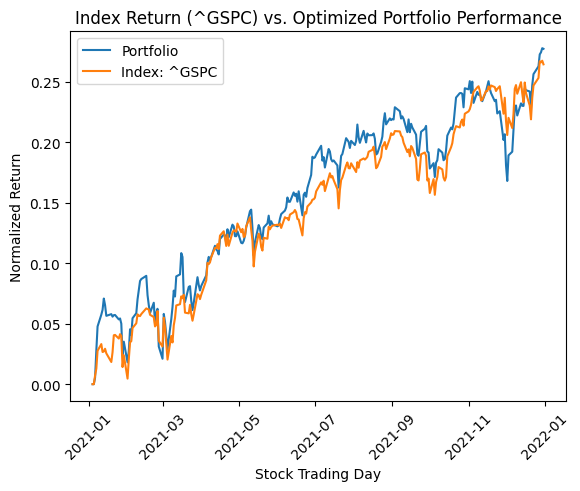

In [8]:
portfolio_returns_back = model_generation.calc_returns(stock_returns, best_solution)

tot_portfolio_ret = [np.sum(portfolio_returns_back[:x]) for x in range(T)]
tot_index_ret = [np.sum(index_returns[:x]) for x in range(T)]

plt.title(f"Index Return ({ind_symbol}) vs. Optimized Portfolio Performance")
plt.plot(stock_returns.index, tot_portfolio_ret, label="Portfolio")
plt.plot(stock_returns.index, tot_index_ret, label=f"Index: {ind_symbol}")
plt.xlabel("Stock Trading Day")
plt.tick_params(axis='x', rotation=45)
plt.ylabel("Normalized Return")
plt.legend()

# Plotting the Portfolio Performance compared to the Index on Forwards Testing

This plots the portfolio's performance compared to the index (SPY) for the forward time period projecting the portfolio performance for the future. This is a real test of the portfolio performance as it shows performance on unseen data.

In [9]:
#Fetching data for the forward time period (to test the model's performance on unseen data)
#Same as above, don't download the data unless necessary
if cache:
    stock_data_forward, stock_returns_forward, index_data_forward, index_returns_forward = model_generation.load_cache("2022", ind_symbol)
else:
    start_date = "2022-01-01"
    end_date = "2022-04-01"
    stock_data_forward, stock_returns_forward, index_data_forward, index_returns_forward = model_generation.download_data(index_name=ind_symbol, start_date=start_date, end_date=end_date)


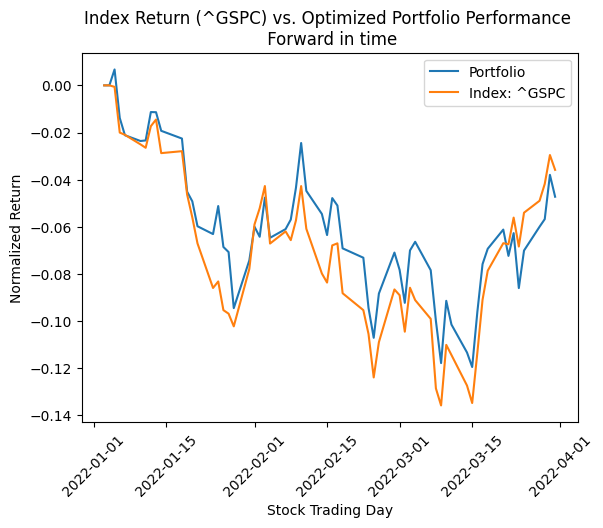

In [10]:
portfolio_returns_forward = model_generation.calc_returns(stock_returns_forward, best_solution)


tot_portfolio_ret = [np.sum(portfolio_returns_forward[:x]) for x in range(len(portfolio_returns_forward))]
tot_index_ret = [np.sum(index_returns_forward[:x]) for x in range(len(index_returns_forward))]

plt.title(f"Index Return ({ind_symbol}) vs. Optimized Portfolio Performance \n Forward in time")
plt.plot(stock_returns_forward.index, tot_portfolio_ret, label="Portfolio")
plt.plot(stock_returns_forward.index, tot_index_ret, label=f"Index: {ind_symbol}")
plt.xlabel("Stock Trading Day")
plt.tick_params(axis='x', rotation=45)
plt.ylabel("Normalized Return")
plt.legend()